# 05-Supervised learning 

In this notebook we will train a model based on the previous 4 notebooks. This include the use of two supervised classifiers named RandomForest and Gradient Boost. We will be using the library of scikitlearn to do this. However, there is no limitation in number of algorithms that can be used, since the notebook has been made modular for further easy implementations of other machine learning algorithms. 

## Table of contents

- Imports 
- Algorithms
- Dataset analysis
    - How do we evaluate the model?
    - Optimal hyperparameter search 
- Running the different algorithms
- Visualizing the cross-validated trained models
    - Interpreting important features used by the models
    - Precision and recall metrics
- Predicting solid-state qubit candidates
    - Save the summary and models

In [1]:
# Optional: Load the "autoreload" extension so that code can change
%load_ext autoreload

#OPTIONAL: Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Imports

In [2]:
import sys
sys.path.insert(0, "../")

from pathlib import Path
data_dir = Path.cwd().parent.parent / "data"
models_dir = Path.cwd().parent.parent / "models" 

print("Current data directory {}".format(data_dir))

Current data directory /home/oliver/Dokumenter/masterprosjekt/predicting-solid-state-qubit-candidates/data


In [3]:
from src.models import train_model, predict_model
from src.features import build_features
from src.visualization import visualize


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [4]:
#Standard libraries
import numpy as np
import pandas as pd
import pickle

#Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# CV
from sklearn.model_selection import RepeatedStratifiedKFold


#visualizations
import plotly.graph_objs as go
from tqdm import tqdm

# setting random seed for reproducibility
random_state=1

In [5]:
InsertApproach = "03-brute-approach"

In [6]:
trainingData   = pd.read_pickle(data_dir / InsertApproach / "processed" / "trainingData.pkl")
trainingTarget= pd.read_pickle(data_dir / InsertApproach / "processed" / "trainingTarget.pkl")
testSet       = pd.read_pickle(data_dir / InsertApproach / "processed" / "testSet.pkl")

trainingData

,material_id,0,1,2,3,4,5,6,7,8,...,1342,1343,1344,1345,1346,1347,1348,1349,1350,full_formula
0,mvc-12905,12.160792,-1.223074,5.339726,-5.317535,-3.055487,-1.138791,1.988872,-0.121662,-0.871082,...,-0.273427,0.336591,-0.045787,-0.057885,0.414090,-0.182081,0.086209,-0.504066,-0.259917,Fe4O8
1,mp-24,15.390432,-2.100071,6.974874,-18.136313,-0.849552,22.896835,4.047144,0.940096,11.068378,...,1.073261,0.214709,1.533368,0.184759,0.010515,0.206998,0.089490,-0.484642,-1.085205,C8
2,mp-47,15.974437,-1.990381,5.997769,-16.993847,1.113514,23.311784,4.658564,1.779796,9.099457,...,0.550601,-0.331581,-0.083221,-1.323363,0.002606,0.563029,-0.731091,0.227452,-0.205986,C4
3,mp-66,15.516921,-1.922371,6.565424,-17.899027,0.469996,24.371473,5.247103,1.522612,10.276007,...,-0.091732,-1.772414,-0.560819,-2.743155,-0.127892,0.518994,-0.446920,0.047568,-0.673894,C2
4,mp-149,8.105998,-1.800003,19.271812,-10.135444,9.742213,11.089157,-1.866398,3.856985,2.434147,...,0.049230,-1.016852,0.277483,-0.567003,-0.530206,-0.262497,1.401910,0.057033,-0.734282,Si2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,mp-1204177,-2.522280,1.391483,-19.597630,3.571239,-3.035571,0.510572,-2.933065,2.742419,-2.914739,...,0.337148,-0.406322,0.240688,0.427418,-0.132172,-0.334497,-0.506344,-0.346412,-0.413360,Na12Co6B18P12H6O76
329,mp-1204243,6.672002,-1.684220,6.197805,15.405713,-12.173409,2.692496,8.228930,-3.349230,-9.995997,...,-0.485193,0.102171,0.401556,0.554164,-0.121179,0.368786,0.090851,-1.036431,0.344988,Rb16Te32O92
330,mp-1204356,11.914016,-1.874037,9.774910,-12.074128,3.065798,17.223304,-1.369682,2.155920,3.941018,...,-0.645304,0.458267,-0.161787,0.935858,-0.031698,0.828300,0.037074,1.163902,0.162440,Si19C19
331,mp-1204627,10.100184,-2.187924,14.933259,-2.687651,9.411496,6.399724,-5.711919,4.145072,-1.430883,...,-0.451751,-0.703477,0.501191,0.114680,-0.601734,-0.048148,0.096061,0.217618,-0.229507,Si46


In [7]:
testSet

,material_id,candidate,0,1,2,3,4,5,6,7,...,1343,1344,1345,1346,1347,1348,1349,1350,full_formula,pretty_formula
333,mp-7,NaN,11.382396,-1.603064,14.105784,-1.535264,14.456148,0.746835,-3.167302,4.480074,...,0.848317,-0.245737,-0.120733,-0.348429,-0.133331,0.542909,0.096415,-0.164069,S6,S
334,mp-14,NaN,7.659246,-2.025535,21.112222,-2.213930,14.552793,0.879710,-1.880726,2.934818,...,-0.098445,0.961075,-0.368102,0.158971,-1.095420,0.335591,-0.518856,-0.401972,Se3,Se
335,mp-19,NaN,4.742011,-2.025088,25.777551,-1.690519,16.911041,1.277128,1.081530,1.597037,...,-2.304971,0.081292,-1.101232,0.553464,-2.183559,0.935412,-3.762214,2.006553,Te3,Te
336,mp-25,NaN,14.144288,-1.559497,7.717777,-2.532565,15.382135,3.334930,5.242774,1.579090,...,0.905354,-0.528949,-0.970799,-0.704016,-1.228755,0.340524,-1.388177,0.647706,N8,N2
337,mp-77,NaN,12.797028,-1.498308,10.675900,4.414804,14.674342,-3.040171,-2.964255,5.421819,...,0.455756,0.347092,-0.039206,-0.770740,0.439060,0.038831,-0.074862,-0.085936,S32,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25199,mp-1539137,NaN,5.348887,-1.922756,8.353021,-3.453272,1.476361,0.105506,-2.123067,0.363185,...,-0.232668,0.169452,0.062242,0.533605,-0.116791,0.505847,0.317126,0.328208,Rb1Cr5S8,RbCr5S8
25200,mp-1541522,NaN,10.822312,-1.018214,8.010707,-3.951969,-4.140112,-2.105142,-1.808684,-0.427604,...,-0.330052,-0.226051,-0.069324,0.530859,0.423646,0.623614,0.406186,-0.515552,Bi2P2O8,BiPO4
25201,mp-1541714,NaN,3.357235,-1.973106,11.054537,-2.490051,7.653624,-9.636225,10.195118,-5.879920,...,0.603967,0.060608,-1.078072,0.434586,-0.145307,0.589755,0.887579,0.247711,Cs3As2Cl9,Cs3As2Cl9
25202,mp-1542038,NaN,3.268168,-1.257995,14.039920,2.794915,6.958190,-2.744119,-9.949436,3.684572,...,-0.248489,0.059962,-0.020813,-0.100417,-0.045622,-0.037345,0.113375,0.017155,Cs2Sn2Se6,CsSnSe3


# Algorithms
Below we define the algorithm to use and its abbreviation. Parameters that are optional to tune are the parameters to the algorithms, with the default value as their optimised value. Another parameter to tune is how many cross-validations one wants to iterate through for the analysis. In addition, one has to find the best features for a new algorithm which will be added further down in the notebook.

In [8]:
InsertAlgorithms    = [LogisticRegression(random_state=random_state),
                       RandomForestClassifier    (random_state=random_state),\
                       GradientBoostingClassifier(random_state=random_state)]
InsertAbbreviations = ["LOG", "RF", "GB"]
InsertprettyNames   = ["Logistic regression", "Random Forest", "Gradient Boost"]

# Dataset analysis


## How do we evaluate the model?

### Cross-validation

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. 

### k-fold cross-validation

In k-fold cross-validation, the sample is partioned into k equal sized subsamples. Of the k samples, a single sample is used as validation set while the remaining k-1 samples are used as training data. The process is then repeated k-times, such that each of the k-th subsample is used as validation set exactly one time. Therefore, all observations are used for both training and validation, and each observation is used for validation exactly once. The k results from the folds can then be averaged to produce an estimate.

### Stratified k-fold cross-validation

In stratified k-fold cross validation, the fold that is selected contains roughly the same proportions of existing class labels. 

### n-repeated stratified k-fold cross-validation

In n-repeated stratified k-fold cross-validation, the stratified k-fold cross-validation is repeated n times, which yields n random partitions of the original sample. The n results can be averaged to produce a single estimation. 

## Sample size
To not discrimate a class, we make sure that each class is equally represented in the subsamples. Underneath shows a brief overview of the different methods involved to deal with this challenge.

### Random oversampling of minority class

Random oversampling can be achived by randomly duplicating examples from the minority class and adding them to the training dataset. 

The approach can be effective to algorithms that are vulnerable to a skewed dsitribution, however, it can also affect algorithms to overfit the minority class. 

### Random Undersampling of majority class

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. 

This can prove problematic, since the loss of data can make the decision boundary between minority and majority instances harder to learn. Additionally, there is a chance that the model might loose valuable information. 

### Both oversampling and undersampling

A third option might be to combine the two of them. 


## Optimal hyperparameters search

In this section we will find the optimal parameters used for the various algorithms. We will use imblearn's Pipeline and its implemented samplers, such as SMOTE and RandomUnderSampler. The advantage of using imblearn instead of sklearn, is that sklearn's pipeline will fit the samplers to the validation data as well, while imblearn only fit the resamplers to the training data. We store the best estimators and use them again under this section.

It is possible to have a large search over a wide amount of properties, but that is indeed extremely cpu-demanding. Therefore, we restrict ourself to the standard choice of some properties, but include a search for properties that can reduce the variance. 

In [9]:
numberRuns=10
numberSplits = 5

includeSampleMethods = [""]#, "under"]#, "over", "both"]

rskfold = RepeatedStratifiedKFold(n_splits=numberSplits, n_repeats=numberRuns, random_state=random_state)

In [10]:
ModelsBestParams = pd.Series({}, dtype="string")

Abbreviations = []
prettyNames   = []
Algorithms = []

for i, algorithm in tqdm(enumerate(InsertAlgorithms)):
    for method in includeSampleMethods:
        print("Finding best params for: {}".format(InsertAbbreviations[i] + " " + method))
        bestEstimator, ModelsBestParams[InsertAbbreviations[i] + " " + method] = train_model.applyGridSearch(
                                                                             X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                                                             y = trainingTarget.values.reshape(-1,),
                                                                        model = algorithm, 
                                                                           cv = rskfold, 
                                                                 sampleMethod = method)
        Abbreviations.append(InsertAbbreviations[i] + " " + method)
        prettyNames.append(InsertAbbreviations[i] + " " + method)
        Algorithms.append(bestEstimator)

0it [00:00, ?it/s]

Finding best params for: LOG 
Fitting 50 folds for each of 1 candidates, totalling 50 fits


1it [00:02,  2.75s/it]

Pipeline(steps=[('model', LogisticRegression(max_iter=200, random_state=1))])
Finding best params for: RF 
Fitting 50 folds for each of 4 candidates, totalling 200 fits


2it [00:15,  8.92s/it]

Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=2, max_features=100,
                                        random_state=1))])
Finding best params for: GB 
Fitting 50 folds for each of 4 candidates, totalling 200 fits


3it [00:27,  9.28s/it]

Pipeline(steps=[('model',
                 GradientBoostingClassifier(max_depth=2, max_features=25,
                                            random_state=1))])


In [11]:
pd.DataFrame(ModelsBestParams["RF "].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_features,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,split42_train_f1,split43_train_f1,split44_train_f1,split45_train_f1,split46_train_f1,split47_train_f1,split48_train_f1,split49_train_f1,mean_train_f1,std_train_f1
0,0.289319,0.059334,0.030198,0.009386,2,25,"{'model__max_depth': 2, 'model__max_features':...",1.0,1.0,0.985075,...,1.0,1.0,0.996416,1.000000,0.996416,1.0,0.996416,0.996416,0.998853,0.001672
1,0.381886,0.064075,0.029455,0.008037,2,50,"{'model__max_depth': 2, 'model__max_features':...",1.0,1.0,0.985075,...,1.0,1.0,1.000000,0.996416,1.000000,1.0,0.996416,0.996416,0.998710,0.001720
2,0.487345,0.104573,0.030016,0.011404,2,75,"{'model__max_depth': 2, 'model__max_features':...",1.0,1.0,0.985075,...,1.0,1.0,0.996416,1.000000,1.000000,1.0,1.000000,1.000000,0.999068,0.001572
3,0.575145,0.089663,0.028349,0.009601,2,100,"{'model__max_depth': 2, 'model__max_features':...",1.0,1.0,0.985075,...,1.0,1.0,0.996416,1.000000,1.000000,1.0,1.000000,0.996416,0.999427,0.001314


# Measuring the best estimators
## Accuracy and f1-score
Under follows the general model runSupervisedModel that takes the as parameter which model to run and returns nice statistics formatted as a dictionary.

In [12]:
print(Algorithms[0]["model"])

LogisticRegression(max_iter=200, random_state=1)


1it [00:00,  6.79it/s]

Current training algorithm: LOG 


50it [00:07,  6.48it/s]


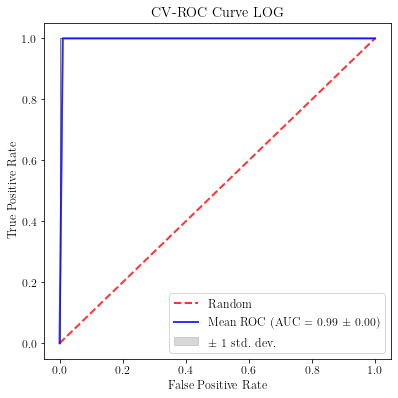

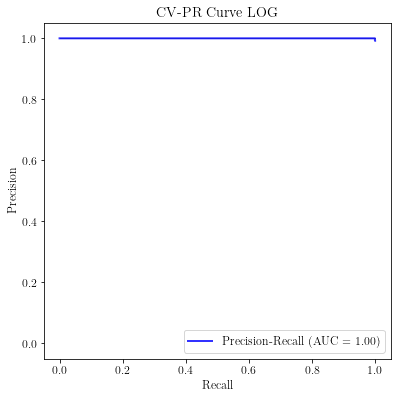

0it [00:00, ?it/s]

Mean accuracy:0.99909
Standard deviation:0.00470
f1-score:1.00000
Current training algorithm: RF 


50it [00:39,  1.26it/s]


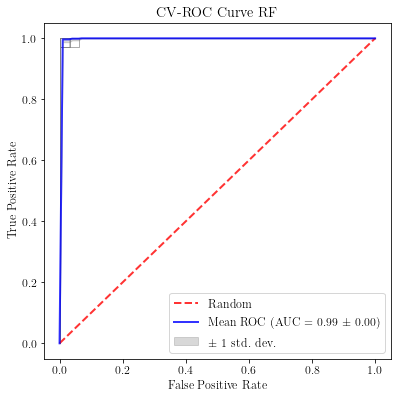

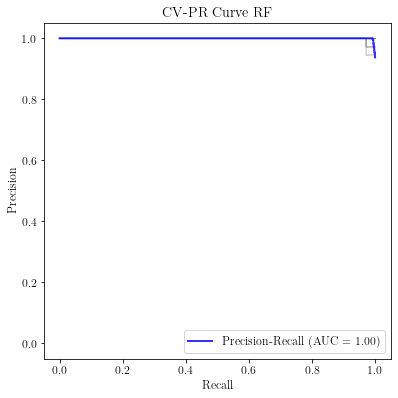

0it [00:00, ?it/s]

Mean accuracy:0.99427
Standard deviation:0.00997
f1-score:1.00000
Current training algorithm: GB 


50it [00:15,  3.32it/s]


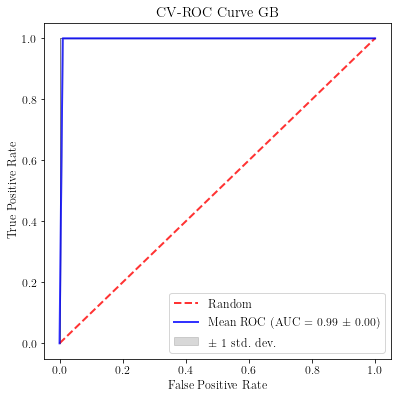

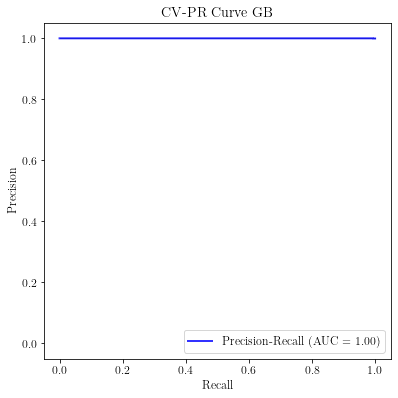

Mean accuracy:0.99699
Standard deviation:0.00799
f1-score:1.00000


In [20]:
SupervisedModels = pd.Series({}, dtype="string")

for i, algorithm in enumerate(Algorithms): 
    print("Current training algorithm: {}".format(prettyNames[i]))
    SupervisedModels[Abbreviations[i]] = (
        visualize.runSupervisedModel(classifier  = algorithm, 
                                     X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                     y = trainingTarget.values.reshape(-1,),
                                     k = numberSplits,
                                     n = numberRuns,
                                    cv = rskfold,
                     featureImportance = True,
                                 title = prettyNames[i])
    )

In [24]:
#SupervisedModels["RF "]

# Visualizing the cross-validated trained models

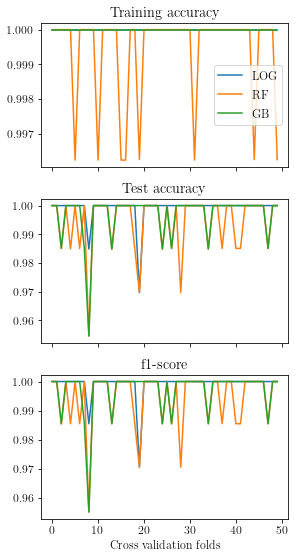

In [25]:
visualize.plot_accuracy(SupervisedModels, prettyNames)

The standard deviation is calculated as a function difference of the $100$ models in the purpose of visalizing how much the models deviate from each other.

## Interpreting important features used by the models

Which features are the most important in predicting to give a label $0$ or $1$?

In [26]:
"""
def plot_important_features(models, names):
    fig = go.Figure( 
            layout = go.Layout (
                title=go.layout.Title(text='Features used in model (Nruns = {})'.format(numberRuns*numberSplits)),
                yaxis=dict(title="Number times"),
                barmode='group'
            )
        )

    for i, model in enumerate(models):
        fig.add_traces(go.Bar(name=names[i], x=trainingData.columns.values, y=model['importantKeys']))

    fig.show()

    fig = go.Figure( 
            layout = go.Layout (
                title=go.layout.Title(text="Feature Importance for the 100th iteration".format(numberRuns*numberSplits)),
                yaxis=dict(title='Relative importance'),
                barmode='group'
            )
        )

    for i, model in enumerate(models):
        fig.add_traces(go.Bar(name=names[i], x=trainingData.columns.values, y=model['relativeImportance']))

    fig.show()
"""
visualize.plot_important_features(SupervisedModels, prettyNames, 
                        X=trainingData.drop(["material_id", "full_formula"], axis=1),
                       k = numberSplits, n = numberRuns)

In [27]:
visualize.plot_important_features_restricted_domain(SupervisedModels, prettyNames, trainingData, k = numberSplits, n = numberRuns)

## Precision and recall metrics

In [28]:
visualize.plot_confusion_metrics(SupervisedModels, prettyNames, trainingData, k = numberSplits, n = numberRuns, abbreviations=prettyNames)

In [19]:
#visualize.plot_confusion_matrixQT(SupervisedModels, trainingTarget, trainingData, names=prettyNames, k = numberSplits, n = numberRuns)

In [20]:
#visualize.confusion_matrixQT(SupervisedModels, trainingTarget, prettyNames)

2it [00:00, 13.09it/s]

Current training algorithm: LOG 


50it [00:03, 12.51it/s]


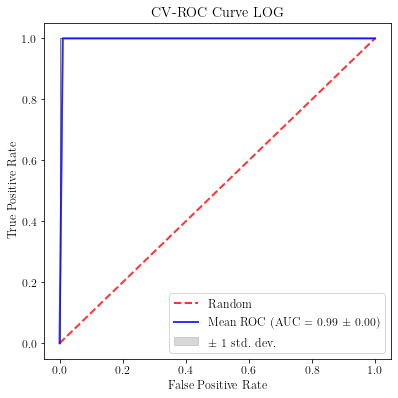

0it [00:00, ?it/s]

Current training algorithm: RF 


50it [00:17,  2.92it/s]


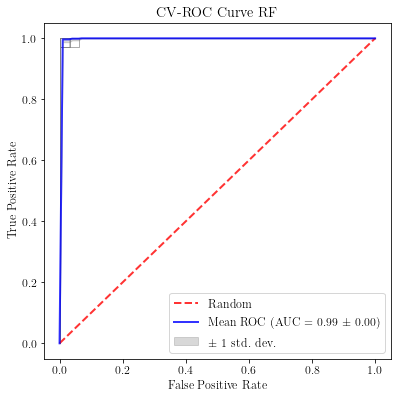

1it [00:00,  7.56it/s]

Current training algorithm: GB 


50it [00:06,  7.99it/s]


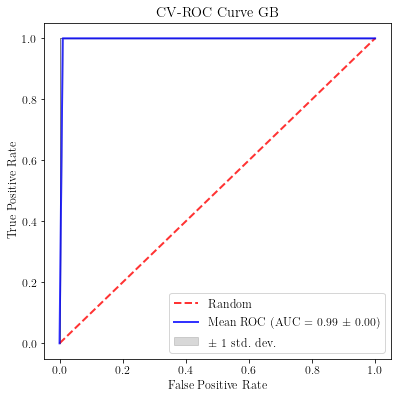

In [21]:
for i, algorithm in enumerate(Algorithms): 
    print("Current training algorithm: {}".format(prettyNames[i]))
    visualize.draw_cv_roc_curve(classifier  = algorithm, 
                                     X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                     y = trainingTarget.values.reshape(-1,),
                                     k = numberSplits,
                                     n = numberRuns,
                                    cv = rskfold,
                                 title = prettyNames[i])
#draw_cv_roc_curve(clf, cv, X, y, title='Cross Validated ROC')


2it [00:00, 13.58it/s]

Current training algorithm: LOG 


50it [00:04, 12.32it/s]


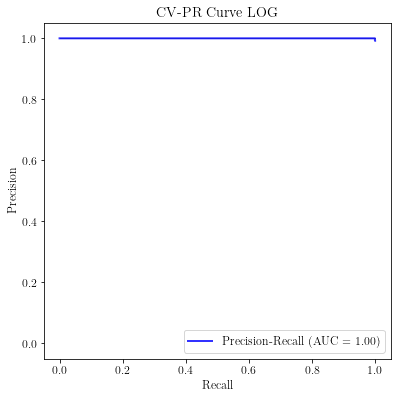

0it [00:00, ?it/s]

Current training algorithm: RF 


50it [00:17,  2.84it/s]


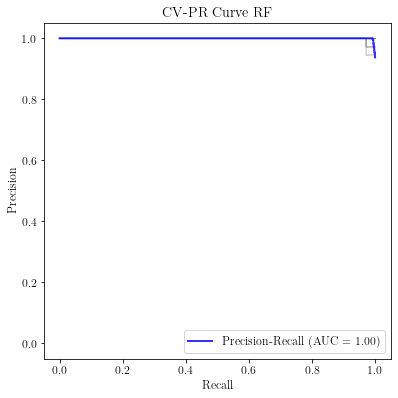

1it [00:00,  7.90it/s]

Current training algorithm: GB 


50it [00:06,  7.82it/s]


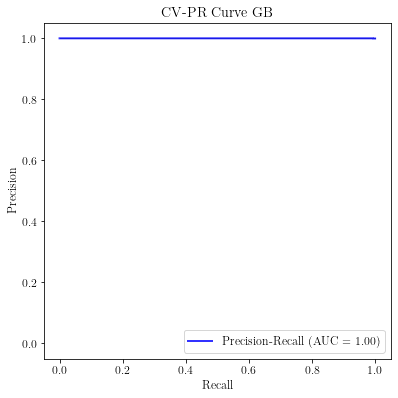

In [22]:
for i, algorithm in enumerate(Algorithms): 
    print("Current training algorithm: {}".format(prettyNames[i]))
    visualize.draw_cv_pr_curve(classifier  = algorithm, 
                                     X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                     y = trainingTarget.values.reshape(-1,),
                                     k = numberSplits,
                                     n = numberRuns,
                                    cv = rskfold,
                                 title = prettyNames[i])

# Predicting solid-state qubit candidates

It is time to make the prediction based on the best estimators and features possible. We have chosen to choose the features that have been deemed important by sklearn at least 50 percent of the cross validation runs as important. 

In [29]:
Path(models_dir / InsertApproach / "trained-models").mkdir(parents=True, exist_ok=True)

Summary                 = pd.DataFrame({}, dtype="string")
Summary["material_id"]  = testSet["material_id"]
Summary["full_formula"] = testSet["full_formula"]
Summary["pretty_formula"] = testSet["pretty_formula"]

PredictedCandidates = pd.Series({}, dtype="string")

threshold = numberSplits*numberRuns/2 #50% when equal
trainSet = trainingData.drop(["material_id", "full_formula"], axis=1)
testData = testSet.drop(["pretty_formula", "candidate", "full_formula", "material_id"], axis=1)
fittedAlgorithms = [] 

for i, algorithm in tqdm(enumerate(Algorithms)):
    
    fittedAlgorithm = train_model.fitAlgorithm(algorithm, 
                                    trainingData   = trainSet,#[trainSet.columns[SupervisedModels[Abbreviations[i]]["importantKeys"]>threshold]],\
                                    trainingTarget = trainingTarget.values.reshape(-1,),)
    
    fittedAlgorithms.append(fittedAlgorithm)
    
    PredictedCandidates[Abbreviations[i]],\
    PredictedCandidates[Abbreviations[i]+"Prob"] = predict_model.runPredictions(fittedAlgorithm,\
                                                        testData = testData)#[testData.columns[SupervisedModels[Abbreviations[i]]["importantKeys"]>threshold]])

3it [00:01,  1.94it/s]


In [30]:
for abbreviation in Abbreviations:
    Summary[abbreviation]            = PredictedCandidates[abbreviation]
    Summary[abbreviation + "Prob"]       = PredictedCandidates[abbreviation + "Prob"]
    print("{} predict the number of candidates as: {}".format(abbreviation, int(np.sum(PredictedCandidates[abbreviation]))))

LOG  predict the number of candidates as: 367
RF  predict the number of candidates as: 328
GB  predict the number of candidates as: 570


In [31]:
Summary

,material_id,full_formula,pretty_formula,LOG,LOG Prob,RF,RF Prob,GB,GB Prob
333,mp-7,S6,S,1.0,0.943779,0.0,0.366204,0.0,0.265424
334,mp-14,Se3,Se,1.0,0.960082,0.0,0.375882,0.0,0.195524
335,mp-19,Te3,Te,1.0,0.965409,0.0,0.430483,0.0,0.181974
336,mp-25,N8,N2,1.0,0.963787,0.0,0.357351,0.0,0.115675
337,mp-77,S32,S,1.0,0.812080,0.0,0.379361,0.0,0.125419
...,...,...,...,...,...,...,...,...,...
25199,mp-1539137,Rb1Cr5S8,RbCr5S8,0.0,0.000634,0.0,0.238659,0.0,0.069736
25200,mp-1541522,Bi2P2O8,BiPO4,0.0,0.003409,0.0,0.173183,0.0,0.013510
25201,mp-1541714,Cs3As2Cl9,Cs3As2Cl9,0.0,0.000550,0.0,0.276168,0.0,0.040001
25202,mp-1542038,Cs2Sn2Se6,CsSnSe3,0.0,0.001991,0.0,0.238349,0.0,0.032971


## Save the summary and models

In [32]:
for i, fitted_algorithm in tqdm(enumerate(fittedAlgorithms)):
    file_path = Path(models_dir / InsertApproach / "trained-models" / Path(prettyNames[i] + ".pkl"))
    with file_path.open("wb") as fp:
        pickle.dump(fitted_algorithm, fp)
        
Path(models_dir / InsertApproach / "summary").mkdir(parents=True, exist_ok=True)        
Summary.to_pickle(models_dir / InsertApproach / "summary" / "summary.pkl")

3it [00:00, 444.36it/s]
